In [13]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [14]:
import pandas as pd

Taiwan_QQQ = pd.read_feather('Cleaned_2022_Reading.feather')

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Reading_level'], axis=1)
y = Taiwan_QQQ['Reading_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

MPIN_score    0.370676
MCUD_score    0.368864
MPEM_score    0.368011
MCCR_score    0.366238
MCQN_score    0.362658
                ...   
IC182Q01JA    0.020565
IC183Q05JA    0.020266
IC176Q08JA    0.020261
ST326Q05JA    0.020128
ST254Q06JA    0.020087
Length: 100, dtype: float64


In [16]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,MPIN_score,MCUD_score,MPEM_score,MCCR_score,MCQN_score,MPRE_score,MPFS_score,MCSS_score,MATHEFF,ICTEFFIC,...,IC176Q07JA,COOPAGR,ST259Q02JA,IC184Q03JA,EMOCOAGR,IC182Q01JA,IC183Q05JA,IC176Q08JA,ST326Q05JA,ST254Q06JA
116617,577.8205,542.8970,553.9917,513.3512,508.3143,539.5791,575.2894,638.8695,-1.5802,-2.6393,...,1.0,-0.8707,5.0,1.0,0.7121,2.0,1.0,1.0,4.0,4.0
113200,726.7294,688.4642,690.6977,713.2503,693.6709,680.9827,691.1397,686.9754,-0.0701,1.9551,...,4.0,0.7133,7.0,1.0,0.5840,4.0,4.0,4.0,5.0,4.0
114431,473.2832,452.3258,490.7346,500.8144,504.3945,510.4740,463.7185,500.9015,-0.2596,1.9495,...,1.0,-0.0429,5.0,1.0,0.2397,3.0,4.0,1.0,9.0,4.0
116880,386.1046,399.4720,366.9445,368.6669,387.2095,381.2168,362.6580,383.9563,-3.4814,-1.1255,...,1.0,-1.1232,6.0,1.0,0.5835,2.0,2.0,1.0,1.0,3.0
114548,294.7983,318.4726,336.8156,329.7622,326.0868,363.1072,360.4285,364.9882,-3.4257,1.9495,...,1.0,-0.2119,8.0,1.0,0.5368,4.0,4.0,1.0,3.0,4.0


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}


# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.8729989327641409
Fold 2 score: 0.8911419423692636
Fold 3 score: 0.8633938100320171
Fold 4 score: 0.8911419423692636
Fold 5 score: 0.8527214514407684
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5325506937033084
Fold 2 score: 0.5336179295624333
Fold 3 score: 0.5336179295624333
Fold 4 score: 0.5314834578441836
Fold 5 score: 0.5314834578441836
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.8452508004268944
Fold 2 score: 0.8420490928495198
Fold 3 score: 0.8633938100320171
Fold 4 score: 0.8655282817502669
Fold 5 score: 0.8377801494130203
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.8729989327641409
Fold 2 score: 0.8911419423692636
Fold 3 score: 0.8633938100320171
Fold 4 score: 0.8911419423692636
Fold 5 score: 0.8527214514407684
Params: {'svm

In [18]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.8665955176093917
Fold 2 score: 0.887940234791889
Fold 3 score: 0.8601921024546425
Fold 4 score: 0.8783351120597652
Fold 5 score: 0.8633938100320171
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.8655282817502669
Fold 2 score: 0.887940234791889
Fold 3 score: 0.8612593383137673
Fold 4 score: 0.8762006403415155
Fold 5 score: 0.8580576307363927
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.8708644610458911
Fold 2 score: 0.8868729989327642
Fold 3 score: 0.8623265741728922
Fold 4 score: 0.8740661686232657
Fold 5 score: 0.8580576307363927
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.871931696905016
Fold 2 score: 0.883671291355

In [19]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.8527214514407684
Fold 2 score: 0.8868729989327642
Fold 3 score: 0.8644610458911419
Fold 4 score: 0.8601921024546425
Fold 5 score: 0.848452508004269
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.8612593383137673
Fold 2 score: 0.8815368196371398
Fold 3 score: 0.8591248665955176
Fold 4 score: 0.8697972251867663
Fold 5 score: 0.8505869797225186
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.8633938100320171
Fold 2 score: 0.8836712913553896
Fold 3 score: 0.8612593383137673
Fold 4 score: 0.8740661686232657
Fold 5 score: 0.8527214514407684
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.8527214514407684
Fold 2 score: 0.8826040554962646
Fold 3 score

In [20]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7972251867662753
Fold 2 score: 0.8089647812166488
Fold 3 score: 0.7822838847385272
Fold 4 score: 0.80042689434365
Fold 5 score: 0.7982924226254002
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.8057630736392742
Fold 2 score: 0.8143009605122732
Fold 3 score: 0.7865528281750267
Fold 4 score: 0.8025613660618997
Fold 5 score: 0.8036286019210246
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.8046958377801494
Fold 2 score: 0.8143009605122732
Fold 3 score: 0.7854855923159018
Fold 4 score: 0.8036286019210246
Fold 5 score: 0.8036286019210246
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.8057630736392742
Fold 2 score: 0.8143009605122732
Fold 3 score: 0.7865528281750267
Fold 4 score: 0.8036286019210246
Fold 5 score: 0.8046958377801494
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.8046958377801494
Fold 2 score: 0.8143009605122732
Fold 3 score: 0.7865528281750267
Fold 4 score: 0.8036286019210246
Fold 5 score: 0.80362860192102

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.8907849829351536

In [22]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

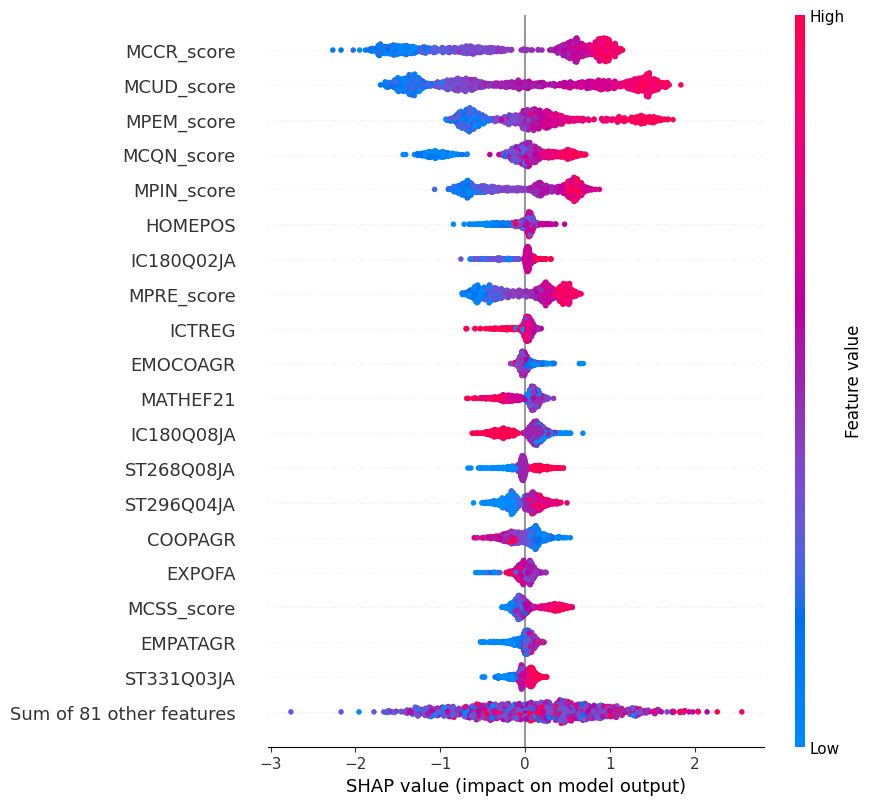

In [23]:
shap.plots.beeswarm(shap_values,max_display=20,order=shap_values.abs.max(0))

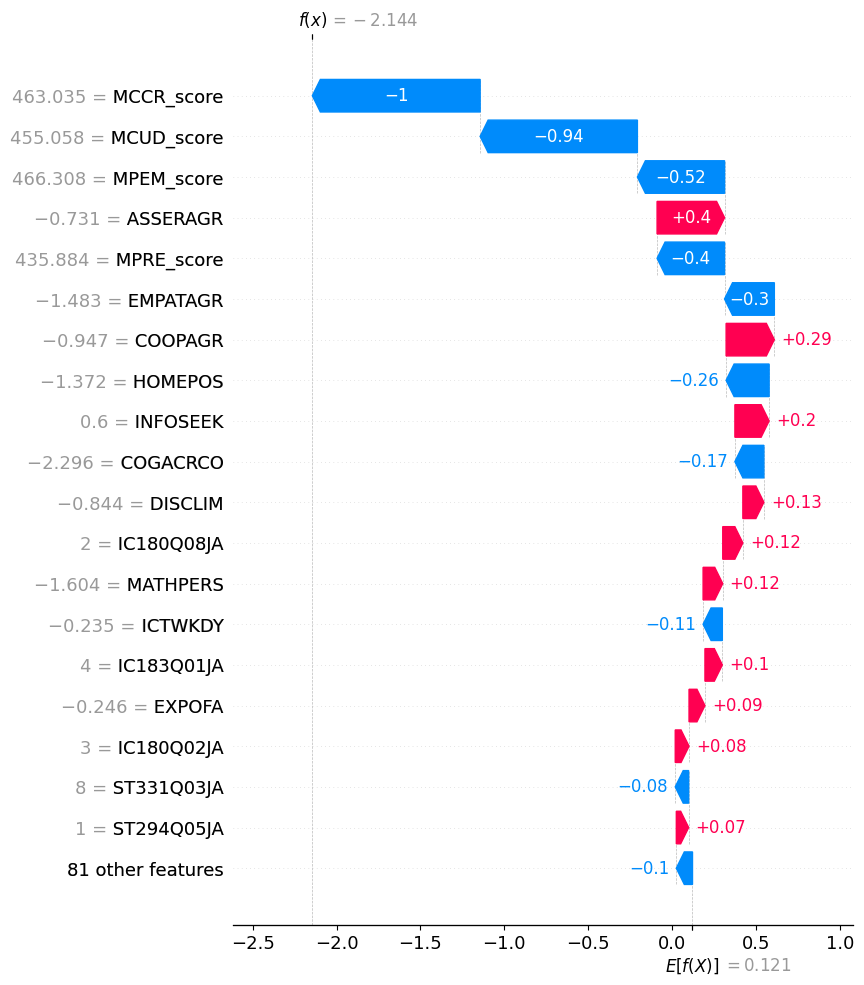

In [25]:
shap.plots.waterfall(shap_values[1], max_display=20)